**Import libraries**

In [1]:
import os
import logging

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [3]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/c-brugo/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

train_initial_indexes = range(len(train_dataset))
train_indexes = train_initial_indexes[::2] # split the indices for your train split
val_indexes = train_initial_indexes[1::2] # split the indices for your val split

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)



# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Accuracy function**

In [6]:
def calc_accuracy(net, dataloader, dataset):
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  if dataloader.drop_last:
    accuracy = running_corrects / float(len(dataloader)*BATCH_SIZE)
  else:
    accuracy = running_corrects / float(len(dataset))
  return accuracy


# **Base Model**

**Prepare Network**

In [7]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [8]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [9]:
columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]


base_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)


# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5 == 0:
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * images.size(0)


    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

  base_df["epoch"][epoch] = epoch+1
  base_df["loss"][epoch] = loss_epoch/float(len(train_dataloader)*BATCH_SIZE)
  base_df["train_accuracy"][epoch] = calc_accuracy(net, train_dataloader, train_dataset)
  base_df["val_accuracy"][epoch] = calc_accuracy(net, val_dataloader, val_dataset)
  # Step the scheduler
  scheduler.step() 

Starting epoch 5/30, LR = [0.001]
Starting epoch 10/30, LR = [0.001]
Starting epoch 15/30, LR = [0.001]
Starting epoch 20/30, LR = [0.001]
Starting epoch 25/30, LR = [0.0001]
Starting epoch 30/30, LR = [0.0001]


**Accuracy & Loss**

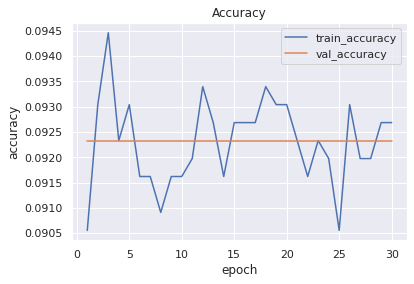

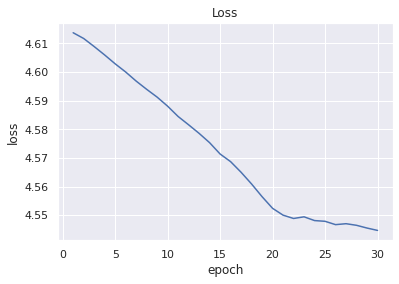

In [10]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=base_df)
plt.plot('epoch', 'val_accuracy', data=base_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()
  
plt.figure()
plt.plot('epoch', 'loss', data=base_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.show()

**Test**

In [11]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {:.2f}%'.format(accuracy*100))

Test Accuracy: 9.19%


# **Transfer Learning**

**Data Preprocessing Normalization**

In [12]:
# Define transforms for training phase
train_imagenet_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with Imagenet's mean and standard deviation
])
# Define transforms for the evaluation phase
eval_imagenet_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                    
])



**Prepare Dataset and Dataloaders**

In [13]:
# Clone github repository with data
if not os.path.isdir('./Caltech101_TL'):
  !git clone https://github.com/c-brugo/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101_TL'

DATA_DIR = 'Caltech101_TL/101_ObjectCategories'
from Caltech101_TL.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_imagenet_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_imagenet_transform)

train_initial_indexes = range(len(train_dataset))
train_indexes = train_initial_indexes[::2] # split the indices for your train split
val_indexes = train_initial_indexes[1::2] # split the indices for your val split

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 9272 (delta 4), reused 10 (delta 2), pack-reused 9260
Receiving objects: 100% (9272/9272), 129.49 MiB | 38.28 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (9152/9152), done.


# **Pretrained Network - Hyperparameters Experiment 1**



**Train**

In [14]:
#AlexNet pretrained
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

LR_1 = 1e-3
STS_1 = 25

criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR_1, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STS_1, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark
columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]
s1_opt_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)

for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5==0:
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0
  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * images.size(0)

    loss.backward()
    optimizer.step()
    
  s1_opt_df["epoch"][epoch] = epoch+1
  s1_opt_df["loss"][epoch] = loss_epoch/float(len(train_dataloader)*BATCH_SIZE)
  s1_opt_df["train_accuracy"][epoch] = calc_accuracy(net, train_dataloader, train_dataset)
  s1_opt_df["val_accuracy"][epoch] = calc_accuracy(net, val_dataloader, val_dataset)

  scheduler.step() 

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 5/30, LR = [0.001]
Starting epoch 10/30, LR = [0.001]
Starting epoch 15/30, LR = [0.001]
Starting epoch 20/30, LR = [0.001]
Starting epoch 25/30, LR = [0.001]
Starting epoch 30/30, LR = [0.0001]


**Accuracy & Loss**

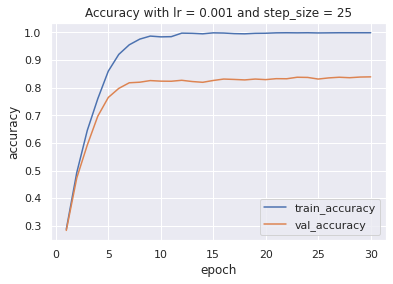

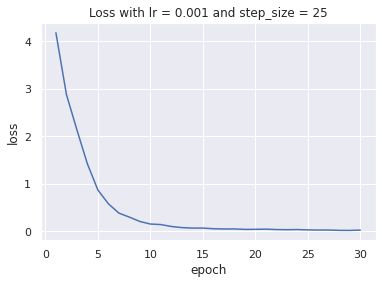

In [15]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=s1_opt_df)
plt.plot('epoch', 'val_accuracy', data=s1_opt_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy with lr = {} and step_size = {}".format(LR_1, STS_1))
plt.legend()
plt.show()
  
plt.figure()
plt.plot('epoch', 'loss', data=s1_opt_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss with lr = {} and step_size = {}".format(LR_1, STS_1))
plt.show()

**Test**

In [16]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {:.2f}%'.format(accuracy*100))

Test Accuracy: 83.58%


# **Pretrained Network - Hyperparameters Experiment 2**

**Train**

In [17]:
#AlexNet pretrained
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

LR_2 = 5e-3
STS_2 = 20

criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR_2, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STS_2, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark

columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]
s2_opt_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)

for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5==0:
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0
  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * images.size(0)

    loss.backward()
    optimizer.step()
    
  s2_opt_df["epoch"][epoch] = epoch+1
  s2_opt_df["loss"][epoch] = loss_epoch/float(len(train_dataloader)*BATCH_SIZE)
  s2_opt_df["train_accuracy"][epoch] = calc_accuracy(net, train_dataloader, train_dataset)
  s2_opt_df["val_accuracy"][epoch] = calc_accuracy(net, val_dataloader, val_dataset)

  scheduler.step() 

Starting epoch 5/30, LR = [0.005]
Starting epoch 10/30, LR = [0.005]
Starting epoch 15/30, LR = [0.005]
Starting epoch 20/30, LR = [0.005]
Starting epoch 25/30, LR = [0.0005]
Starting epoch 30/30, LR = [0.0005]


**Accuracy & Loss**

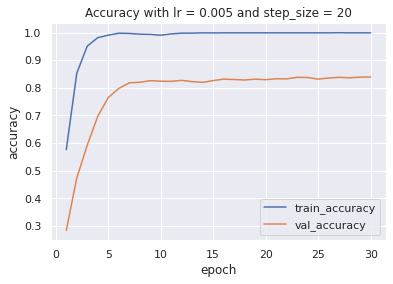

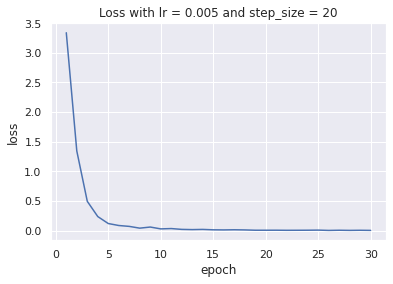

In [18]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=s2_opt_df)
plt.plot('epoch', 'val_accuracy', data=s1_opt_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy with lr = {} and step_size = {}".format(LR_2, STS_2))
plt.legend()
plt.show()
  
plt.figure()
plt.plot('epoch', 'loss', data=s2_opt_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss with lr = {} and step_size = {}".format(LR_2, STS_2))
plt.show()

**Test**

In [19]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {:.2f}%'.format(accuracy*100))

Test Accuracy: 84.27%


# **Pretrained Network - Hyperparameters Experiment 3**

**Train**

In [20]:
#AlexNet pretrained
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

LR_3 = 1e-2
STS_3 = 13

criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
optimizer = optim.SGD(parameters_to_optimize, lr=LR_3, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STS_3, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark
columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]
s3_opt_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)

for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5==0:
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0
  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * images.size(0)

    loss.backward()
    optimizer.step()
    
  s3_opt_df["epoch"][epoch] = epoch+1
  s3_opt_df["loss"][epoch] = loss_epoch/float(len(train_dataloader)*BATCH_SIZE)
  s3_opt_df["train_accuracy"][epoch] = calc_accuracy(net, train_dataloader, train_dataset)
  s3_opt_df["val_accuracy"][epoch] = calc_accuracy(net, val_dataloader, val_dataset)

  scheduler.step() 

Starting epoch 5/30, LR = [0.01]
Starting epoch 10/30, LR = [0.01]
Starting epoch 15/30, LR = [0.001]
Starting epoch 20/30, LR = [0.001]
Starting epoch 25/30, LR = [0.001]
Starting epoch 30/30, LR = [0.0001]


**Accuracy & Loss**

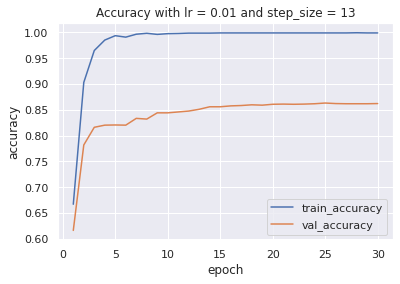

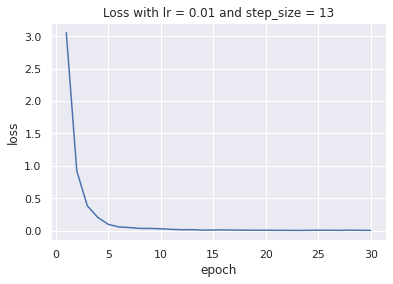

In [21]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=s3_opt_df)
plt.plot('epoch', 'val_accuracy', data=s3_opt_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy with lr = {} and step_size = {}".format(LR_3, STS_3))
plt.legend()
plt.show()
  
plt.figure()
plt.plot('epoch', 'loss', data=s3_opt_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss with lr = {} and step_size = {}".format(LR_3, STS_3))
plt.show()

**Test**

In [22]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {:.2f}%'.format(accuracy*100))

Test Accuracy: 84.69%


# **Training on fully connected layers**

**Train**

In [23]:
#AlexNet pretrained
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

LR = 1e-3
STS = 25

criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.classifier.parameters() # In this case we optimize over only the fully connected layer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STS, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark

columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]
fcl_opt_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)

for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5==0:
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0
  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * images.size(0)

    loss.backward()
    optimizer.step()
    
  fcl_opt_df["epoch"][epoch] = epoch+1
  fcl_opt_df["loss"][epoch] = loss_epoch/float(len(train_dataloader)*BATCH_SIZE)
  fcl_opt_df["train_accuracy"][epoch] = calc_accuracy(net, train_dataloader, train_dataset)
  fcl_opt_df["val_accuracy"][epoch] = calc_accuracy(net, val_dataloader, val_dataset)

  scheduler.step() 

Starting epoch 5/30, LR = [0.001]
Starting epoch 10/30, LR = [0.001]
Starting epoch 15/30, LR = [0.001]
Starting epoch 20/30, LR = [0.001]
Starting epoch 25/30, LR = [0.001]
Starting epoch 30/30, LR = [0.0001]


**Accuracy & Loss**

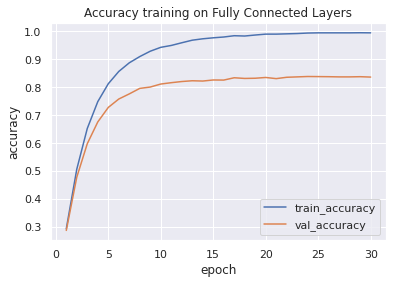

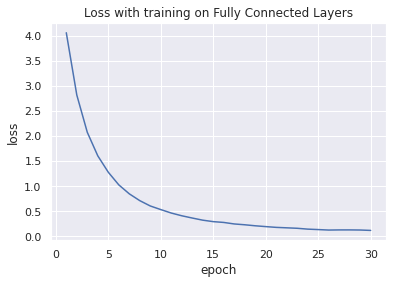

In [24]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=fcl_opt_df)
plt.plot('epoch', 'val_accuracy', data=fcl_opt_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy training on Fully Connected Layers")
plt.legend()
plt.show()
  
plt.figure()
plt.plot('epoch', 'loss', data=fcl_opt_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss with training on Fully Connected Layers")
plt.show()

**Test**

In [25]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {:.2f}%'.format(accuracy*100))

Test Accuracy: 83.20%


# **Training on convolutional layers**

**Train**

In [26]:
#AlexNet pretrained
net = alexnet(pretrained=True)
net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

LR = 1e-3
STS = 25

criterion = nn.CrossEntropyLoss()
parameters_plus_lastfc = list(net.features.parameters()) + list(net.classifier[6].parameters())
parameters_to_optimize =  (p for p in parameters_plus_lastfc) # In this case we optimize over only the convolutional layer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STS, gamma=GAMMA)

net = net.to(DEVICE)
cudnn.benchmark

columns = ["epoch", "train_accuracy", "val_accuracy", "loss"]
cvl_opt_df = pd.DataFrame(index=range(NUM_EPOCHS), columns=columns)

for epoch in range(NUM_EPOCHS):
  if (epoch+1)%5==0:
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  loss_epoch = 0
  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad()
    outputs = net(images)
    loss = criterion(outputs, labels)
    loss_epoch += loss.item() * images.size(0)

    loss.backward()
    optimizer.step()
    
  cvl_opt_df["epoch"][epoch] = epoch+1
  cvl_opt_df["loss"][epoch] = loss_epoch/float(len(train_dataloader)*BATCH_SIZE)
  cvl_opt_df["train_accuracy"][epoch] = calc_accuracy(net, train_dataloader, train_dataset)
  cvl_opt_df["val_accuracy"][epoch] = calc_accuracy(net, val_dataloader, val_dataset)

  scheduler.step() 

Starting epoch 5/30, LR = [0.001]
Starting epoch 10/30, LR = [0.001]
Starting epoch 15/30, LR = [0.001]
Starting epoch 20/30, LR = [0.001]
Starting epoch 25/30, LR = [0.001]
Starting epoch 30/30, LR = [0.0001]


**Accuracy & Loss**

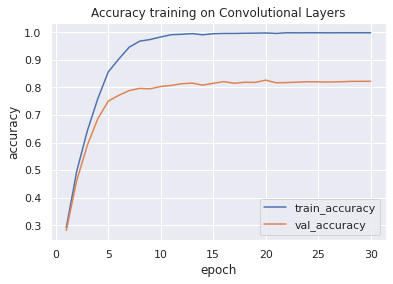

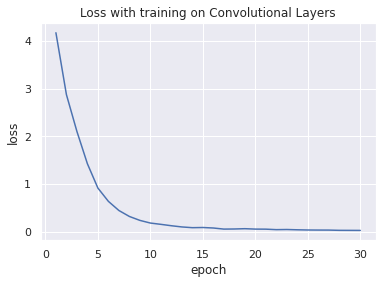

In [27]:
plt.figure()
plt.plot('epoch', 'train_accuracy', data=cvl_opt_df)
plt.plot('epoch', 'val_accuracy', data=cvl_opt_df)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy training on Convolutional Layers")
plt.legend()
plt.show()
  
plt.figure()
plt.plot('epoch', 'loss', data=cvl_opt_df)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss with training on Convolutional Layers")
plt.show()

**Test**

In [28]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {:.2f}%'.format(accuracy*100))

Test Accuracy: 82.03%
